# USG grants crawl

Imagine that we wanted to crawl 

In [15]:
from bs4 import BeautifulSoup
import xmltodict

# load up the xml file
pathToXML='C://Users//dbullock//Documents//code//gitDir//USG_grants_crawl//inputData//GrantsDBExtract20230113v2.xml'

# open and parse file
with open(pathToXML, 'r') as f:
    govGrantData_raw = f.read()

# convert xml to dictionary
with open(pathToXML) as xml_file:
    govGrantData_dict = xmltodict.parse(xml_file.read())

# terminal reports
print('Dictionary conversion successful')
print('\n' + str(len(govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0'])) + ' grant entries found.')
print('\n with dictionary keys:\n')
print(govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0'].keys())

Dictionary conversion successful
70330grant entries found


In [41]:
# let's do some initial dataset overview
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itables

# create a blank list to hold the unique agency identifiers
agencyList=[]
for iListing in govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0']:
    # why are you like this government agencies
    try:    
        # in the normal case
        agencyList.append(iListing['AgencyCode'].split('-')[0])
    except:
        try:
            # if its not there, get the full name
            agencyName=iListing['AgencyName']
            # and extract the capital letters
            agencyList.append([char for char in agencyName if char.isupper()])
        except:
            # well, if you can't adhere to a formatting standard, then you get lumped into other
            agencyList.append('other')
            
# quick and dirty pie chart from chat GPT
def plot_pie(list):
    plt.figure(figsize=(12,8), dpi= 100)
    unique_elements, counts_elements = np.unique(list, return_counts=True)
    plt.pie(counts_elements, labels=unique_elements, autopct='%1.1f%%', shadow=True, startangle=140, explode=[.1 for iAgency in unique_elements])
    plt.axis('equal')
    plt.show()
# not a good visualization, so don't do it
# plot_pie(agencyList)

# instead just get the unique elements and their total counts, e.g. 'histcounts'
unique_elements, counts_elements = np.unique(agencyList, return_counts=True)
# create a dataframe to hold these
grantCountDF=pd.DataFrame( data=zip(unique_elements,counts_elements,np.divide(counts_elements,np.sum(counts_elements))),columns=['AgencyName','GrantCount','PortionOfTotal'] )
# interactive display
itables.show(grantCountDF)

In [53]:
# a deeper dive
grantCountDF['totalValue']=0
grantCountDF['totalValuePortion']=0

# let's add some financial context to this
# iterate through the grants
for iListing in govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0']:
    # this time we're just getting the relevant agency label
    # yes, we're redoing what occured in the previous block
    # why are you like this government agencies
    try:    
    # in the normal case
        nameHold=iListing['AgencyCode'].split('-')[0]
        # add the current grant value to the total
    except:
        try:
            # if its not there, get the full name
            agencyName=iListing['AgencyName']
            # and extract the capital letters
            nameHold=([char for char in agencyName if char.isupper()])
        except:
            # well, if you can't adhere to a formatting standard, then you get lumped into other
            nameHold='other'
             #add the current grant value to the total
            
    # now that you have the name holder, try and find the value
    try:
        # if you can find the expected program funding value, add it to the running sum for that agency
        grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]=grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]+int(iListing['EstimatedTotalProgramFunding'])
    except:
        # if you can't
        try:
            # try and infer a value, if the data is avaialble
            # do this by estimating the mean grant value, and multiplying by the expected number of grant awards
            totalAvgValue=np.multiply(np.divide((int(iListing['AwardCeiling'])+int(iListing['AwardFloor'])),2),iListing['ExpectedNumberOfAwards'])
            # add that value to the runing sum
            grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]=grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]+totalAvgValue
        except:
            pass
            # dont bother adding anything

# add a column to the output data frame for the portion of total grant funding
grantCountDF['totalValuePortion']=np.divide(grantCountDF['totalValue'],np.sum(grantCountDF['totalValue']))
# save it down
grantCountDF.to_csv('agencyGrantsSummary.csv')
# interactive display
itables.show(grantCountDF)

C:\Users\dbullock\AppData\Local\Temp\1\ipykernel_20240\3718618052.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]=grantCountDF['totalValue'].loc[grantCountDF['AgencyName']==nameHold]+int(iListing['EstimatedTotalProgramFunding'])


In [82]:
# NOTEBOOK USAGE NOTE FOR THIS BLOCK
# due to the heterogenity of the grant xml structure, it's advised that you NOT run this block -- it will error
# certian keys/fields (e.g. 'EligibleApplicants' and 'CFDANumbers') have been observed to have multiple records
# within a single grant.  Thus, the associated value for these (when collapsed into a dictionary-like structure)
# is not a single item (e.g. string, int, or float), but rather a list.
# this makes concatenation difficult to acheive in a principled manner
# (or in a way that permits saving to a conventional output)

# use this as a switch to control whether this box runs or not, 
# when defaultOffSiwtch=False , the content of this box will not run
defaultOffSiwtch=False

if defaultOffSiwtch:
    # theoretically, you might wish to convert the entire grant archive xml to a an output file
    # this is how you would do that
    grantsDataFrame=pd.DataFrame.from_records(govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0'])
    # NOTE THOUGH: some of the fields (e.g. description) include characters that would otherwise be delimiters (e.g. ',')
    # if you want to save this, you'll have to be clever
    
    # in any case
    # replace the na values with 0
    grantsDataFrame=grantsDataFrame.fillna(0)
    
    # next, convert the numeric columns to actual numbers
    # start by getting the column names, you'll be iterating across them
    columnNames=list(grantsDataFrame.columns.values)
    # now iterate across them and see if they are numeric, and do so robustly
    for iColumns in columnNames:
        print(iColumns)
        # if the first value is numeric-ish (e.g. ignoring a single decimal and negative sign)
        if grantsDataFrame[iColumns].iloc[0].replace('.','',1).replace('-','',1).isdigit():
            # convert it in a type-appropriate way
            # if it has a decimal
            if '.' in grantsDataFrame[iColumns].iloc[0]:
                # convert it to float
                grantsDataFrame[iColumns]=grantsDataFrame[iColumns].astype(float)
            else:
                # otherwise, I guess it's an int
                grantsDataFrame[iColumns]=grantsDataFrame[iColumns].astype(int)
            grantsDataFrame[iColumns]
            
    # interactive display
    itables.show(grantsDataFrame)

C:\Users\dbullock\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


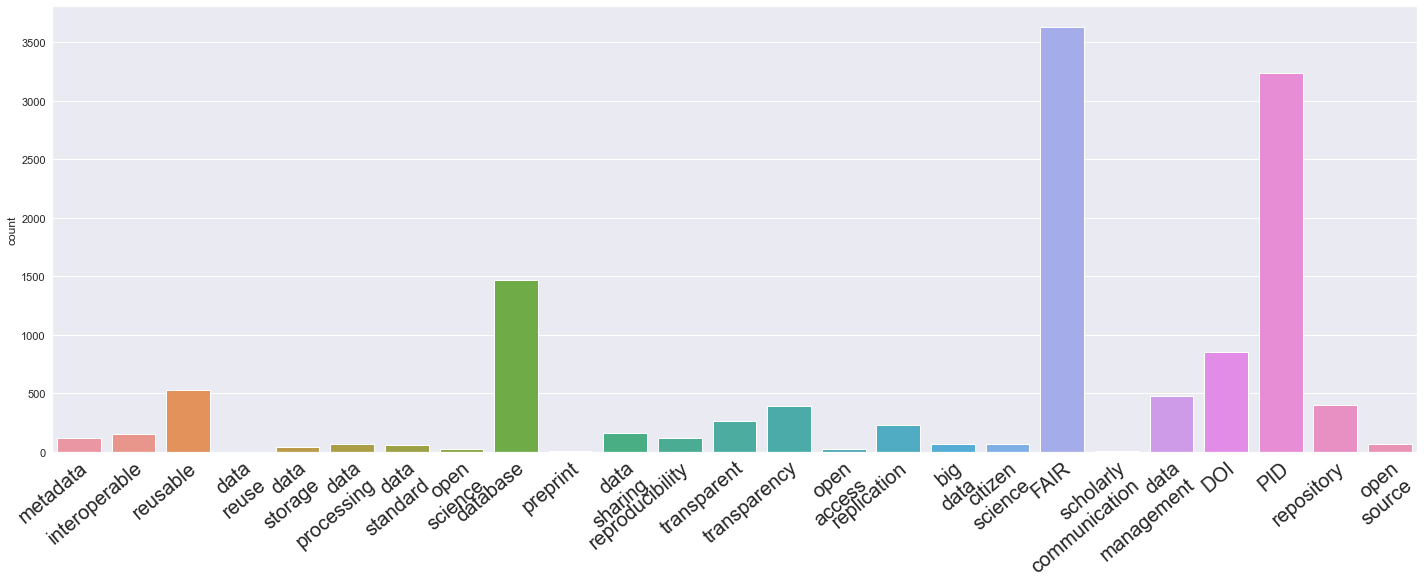

In [136]:
import json
import seaborn as sns
import itertools

# open the keywords file
with open('keywords.txt', 'r') as f:
    keywords = f.read()

# split it into a list.  Each term is kept on a separate line
keywords=keywords.split('\n')

# create a dictionary which will be saved as a json, so that you don't have to do this each time
grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    for iListing in govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0']:
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if iKeywords.lower() in  iListing['Description'].lower():
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound

# save it out
with open("grantFindsOut.json", "w") as outfile:
    json.dump(grantFindsOut, outfile)
    
# plot a histogram
#silly way to do this, but seaborn was giving me issues
import itertools
keywordCountVec=[]
for iKeywords in list(grantFindsOut.keys()):
    currVec=[iKeywords.replace('_','\n')] * len(grantFindsOut[iKeywords])
    keywordCountVec.extend(currVec)

import seaborn as sns
keywordHistDF=pd.DataFrame(data=keywordCountVec, columns=['keyword'])
#keywordHistDF.loc[0:10]=[len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]
#keywordHistDF
sns.set(rc={'figure.figsize':(20,8.27)})
ax=sns.countplot(keywordCountVec)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",rotation_mode='anchor',fontsize=20)
#ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
plt.tight_layout()
plt.show()

In [164]:
# ok, lets create a matrix that holds co-occurance data
# let's start by making a blank matrix to hold the data
connectivityMatrix=np.zeros((len(grantFindsOut.keys()),len(grantFindsOut.keys())), dtype=np.int32())
# also make a list to hold the rows from this
dfRowContentAll=[]
# should be symmetric so x and y doesn't really matter
# iterate across both axes


for iIndexX, iKeywordsX in enumerate(list(grantFindsOut.keys())):
    for iIndexY, iKeywordsY in enumerate(list(grantFindsOut.keys())):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX]
        IDsY=grantFindsOut[iKeywordsY]
        # find the intersection
        intersectionGrants=list(set(IDsX) & set(IDsY))
        # find the size of that intersection
        sharedGrantNum=len(intersectionGrants)
        connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
        # do components for dataframe
        if iKeywordsX==iKeywordsY:
            # half it for the visualization for self connections
            #dfRowContent=[iKeywordsX, iKeywordsY, np.divide(sharedGrantNum,2).astype(np.int32)]
            # or set it to zero
            dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')' , 0]
        else:
            dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')', sharedGrantNum]
        dfRowContentAll.append(dfRowContent)

flatConMatrix=pd.DataFrame(data=dfRowContentAll, columns=['keyword1','keyword2','value'])

from d3blocks import D3Blocks
# Initialize
d3 = D3Blocks()
# change the column names to what's required by d3blocks
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html
flatConMatrix=flatConMatrix.rename(columns={"keyword1": "source", "keyword2": "target", 'value': 'weight'})
# notebook= True doesn't seem to work
# d3.chord(flatConMatrix,filepath=None,notebook=True)
d3.chord(flatConMatrix)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Display in notebook using IPython.


In [182]:
# ok we can also try and use these co occurances to threshold the grants and find other shared words

grantIDholder=[]
# begin by using the same code as above to identify grants which occur more than a certian number of times
for iIndexX, iKeywordsX in enumerate(list(grantFindsOut.keys())):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX]
        grantIDholder.extend(IDsX)

# now that we have a vector with those ID's let's get the description content

#actually, we first have to get a list of the grant IDs
allGrantIDs=[]
for iListing in govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0']:
    allGrantIDs.append(iListing['OpportunityID'])

#create a holder
grantDescriptions=[]

for iGrantIDs in grantIDholder:
    currentGrantIndex=allGrantIDs.index(iGrantIDs)
    currentDescription=govGrantData_dict['Grants']['OpportunitySynopsisDetail_1_0'][currentGrantIndex]['Description']
    grantDescriptions.append(currentDescription.lower())
    
omnibusWordBag=' '.join(grantDescriptions)

# load the stopword bag
with open('stopwords.txt') as f:
    stopwords = f.read()

# iterate through the stopwords bag
for iStopwords in stopwords.split('\n'):
    iStopwords
    omnibusWordBag=omnibusWordBag.replace(' '+iStopwords+' ',' ')
    omnibusWordBag=omnibusWordBag.replace(' '+iStopwords+'.','')
    
# split the bag of words into individual words
allWordsList=omnibusWordBag.split(' ')

#do the counting
unique_elements, counts_elements = np.unique(allWordsList, return_counts=True)
wordCountsDF=pd.DataFrame(np.asarray([unique_elements,counts_elements]).T,columns=['words','counts'])
#show it
itables.show(wordCountsDF)

MemoryError: Unable to allocate 25.9 GiB for an array with shape (3006099,) and data type <U2311

In [96]:
np.asarray([len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]).T

array([ 119,  154,  524,    1,   37,   66,   60,   23, 1471,    7,  163,
          0,  118,    0,  267,  392,   20,  226,   67,   63, 3626,    9,
        474,  856, 3237,  400,   66,    0])

28